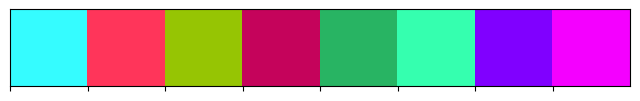

In [ ]:
import numpy as np
import pandas as pd
import json

import matplotlib.pyplot as plt
from matplotlib import patches as patches
import cv2

import os
import shutil as sh

from pathlib import Path
import re
from tqdm import tqdm

import torch

import warnings
warnings.simplefilter("ignore")

import seaborn as sns
import sys
sys.path.insert(0, "../input/weightedboxesfusion")
from ensemble_boxes import *


from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from sklearn.model_selection import train_test_split

import io
import base64

import time
from IPython.display import clear_output
from IPython.display import HTML


custom_colors = ['#35FCFF', '#FF355A', '#96C503', '#C5035B', '#28B463', '#35FFAF', '#8000FF', '#F400FF']
hex2rgb = lambda hx: (int(hx[1:3],16),int(hx[3:5],16),int(hx[5:7],16))
rgbcolors = list(map(hex2rgb, custom_colors))[1:]
sns.palplot(sns.color_palette(custom_colors))

In [ ]:
# install any fonts
!wget -O bitwise.zip https://www.1001freefonts.com/d/8190/bitwise.zip
!unzip bitwise.zip

--2024-01-29 13:19:38--  https://www.1001freefonts.com/d/8190/bitwise.zip
Resolving www.1001freefonts.com (www.1001freefonts.com)... 104.26.1.140, 104.26.0.140, 172.67.72.212, ...
Connecting to www.1001freefonts.com (www.1001freefonts.com)|104.26.1.140|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /bitwise.font [following]
--2024-01-29 13:19:39--  https://www.1001freefonts.com/bitwise.font
Reusing existing connection to www.1001freefonts.com:443.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘bitwise.zip’

bitwise.zip             [ <=>                ]  41.56K  --.-KB/s    in 0.001s  

2024-01-29 13:19:40 (65.4 MB/s) - ‘bitwise.zip’ saved [42559]

Archive:  bitwise.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this

helper functions

In [ ]:
def plot_data_example(df: pd.DataFrame,
                      root_dir: str,
                      img_path: str,
                      colors: dict):

    image = cv2.imread(os.path.join(root_dir, img_path)).astype("uint8")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    boxes = np.zeros(image.shape, dtype="uint8")

    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(25, 8))
    ax[1].imshow(image, aspect="auto")
    ax[1].set_title("Original Image", fontsize=22, fontweight='bold', y=1.07)
    ax[0].set_title("Image with Bounding Boxes", fontsize=22, fontweight='bold', y=1.07)


    bb_info = df.loc[df["pathname"] == img_path, ["x_min", "x_max", "y_min", "y_max", "category"]].values
    for i_bb in bb_info:

        cmin, cmax, rmin, rmax = i_bb[:-1].astype('int')
        label = i_bb[-1]
        bbox = patches.Rectangle((cmin,rmin),cmax-cmin,rmax-rmin,linewidth=1,
                                 edgecolor=label2hex[label], facecolor='none')
        boxes[rmin:rmax, cmin:cmax] = label2rgb[label]

        ax[0].add_patch(bbox)
        ax[0].text(cmin, rmin, label, bbox=dict(fill=True, color=label2hex[label]))
        ax[0].imshow(image, aspect="auto")
        ax[0].imshow(boxes,  alpha=0.3, aspect="auto")
        ax[0].text(cmin, rmin, label, bbox=dict(fill=True, color=label2hex[label]))

    plt.tight_layout()
    fig.savefig("data_exemple1.svg", format='svg', bbox_inches='tight', pad_inches=0.2)
    fig.savefig("data_exemple1.png", format='png', bbox_inches='tight', pad_inches=0.2)
    plt.show()


def plot_image_with_bb(df: pd.DataFrame,
                       root_dir: str,
                       img_path: str,
                       path_to_save: str,
                       dpi: float=100,
                       write: bool=True):

    image = cv2.imread(os.path.join(root_dir, img_path)).astype("uint8")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    boxes = np.zeros(image.shape, dtype="uint8")
    h, w, _ = image.shape
    figsize = (w / dpi), (h / dpi)

    fig, ax = plt.subplots(sharey=True, figsize=(figsize))
    fig.add_axes([0, 0, 1, 1])

    bb_info = df.loc[df["pathname"] == img_path, ["x_min", "x_max", "y_min", "y_max", "category"]].values
    for i_bb in bb_info:

        cmin, cmax, rmin, rmax = i_bb[:-1].astype('int')
        label = i_bb[-1]
        bbox = patches.Rectangle((cmin,rmin),cmax-cmin,rmax-rmin,linewidth=1,
                                 edgecolor=label2hex[label], facecolor='none')
        boxes[rmin:rmax, cmin:cmax] = label2rgb[label]
        ax = plt.gca()
        ax.add_patch(bbox)
        plt.text(cmin, rmin, label, bbox=dict(fill=True, color=label2hex[label]))
        plt.imshow(image, aspect="auto")
        plt.imshow(boxes,  alpha=0.3, aspect="auto")
        plt.text(cmin, rmin, label, bbox=dict(fill=True, color=label2hex[label]))

    plt.tight_layout()
    #plt.axis("off")                                            ## dont work in kaggle kernel
    fig.axes[0].get_xaxis().set_visible(False)                  ## work in kaggle kernel
    fig.axes[0].get_yaxis().set_visible(False)

    if write:
        img_name = img_path.replace('/', '.').split('.')[-2]
        #fig.savefig(f"{path_to_save}/{img_name}.svg", format='svg', bbox_inches='tight', pad_inches=0.2)
        fig.savefig(f"{path_to_save}/{img_name}.png", format='png', bbox_inches='tight', pad_inches=0.0)
        plt.close()
    else:
        plt.show()


def plot_sample(image: torch.Tensor,
                boxes: torch.Tensor,
                labels: torch.Tensor):
    boxes = boxes.cpu().numpy().astype(np.int32)
    labels = labels.cpu().numpy().astype(np.int32)
    image = image.permute(1,2,0).cpu().numpy()
    image = (image * 255).astype(np.uint8)
    masks = np.zeros_like(image)

    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    for label, box in zip(labels, boxes):
        color = label2rgb[label]
        text = label2category[label]
        cmin, rmin, cmax, rmax = box

        cv2.rectangle(image,
                    (cmin, rmin),
                    (cmax, rmax),
                    color=color, thickness=3,)
        cv2.putText(image, text, (cmin, rmin), cv2.FONT_HERSHEY_SIMPLEX, 1,
                    color, 3, cv2.LINE_AA, False,)

        masks[rmin:rmax, cmin:cmax] = color

    image_with_masks = cv2.addWeighted(image, 0.7, masks, 0.7, 0)
    ax.set_axis_off()
    ax.imshow(image_with_masks)


def create_video(path_to_imgs: str, video_name: str, framerate: int):
    """
    Create video from images.
    Params:
        path_to_imgs: path to dir with images.
        video_name: name for saving video.
        framerate: num frames per sec in video.
    """
    frame_width, frame_height = 1600, 1200
    img_names = sorted(os.listdir(path_to_imgs))
    img_path = os.path.join(path_to_imgs, img_names[0])

    fourc = cv2.VideoWriter_fourcc(*'XVID')
    video = cv2.VideoWriter(video_name + ".avi",
                            fourc,
                            framerate,
                            (frame_width, frame_height))

    for img_name in img_names:
        img_path = os.path.join(path_to_imgs, img_name)
        image = cv2.imread(img_path)
        image = cv2.resize(image, (frame_width, frame_height))
        video.write(image)

    cv2.destroyAllWindows()
    video.release()

def show_video(video_path: str):
    """
    show video in jupyter notebook, agent interaction in environment.
    Takes - path to video file.
    Returns - html video player in jupyter notebook.
    """
    video = io.open(video_path, 'r+b').read()
    encoded = base64.b64encode(video)

    return HTML(data='''<video alt="test" width="800" height="400" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4" /"> </video>'''
    .format(encoded.decode('ascii')))

In [ ]:
# Global veriables

class GlobalConfig:
        root_dir = '../input/malaria-bounding-boxes/malaria/'
        train_json_path = '../input/malaria-bounding-boxes/malaria/training.json'
        test_json_path = '../input/malaria-bounding-boxes/malaria/test.json'
        yolo_weights = '../input/malaria/yolov5x_malaria.pt'
        fasterrcnn_weights = '../input/malaria/fasterrcnn_resnet50_fpn.pth'
        seed = 33

def seed_everything(seed: int):
    np.random.seed(seed)
    torch.manual_seed(seed)
    #torch.cuda.manual_seed(seed)

config = GlobalConfig()
seed_everything(config.seed)

# Data Preparation

In [ ]:
train_df = pd.read_json(config.train_json_path)
test_df = pd.read_json(config.test_json_path)
print(train_df.shape, test_df.shape)

(1208, 2) (120, 2)


In [ ]:
df = pd.concat([train_df, test_df]).reset_index(drop=True)
df.head()

image  \
0  {'checksum': '676bb8e86fc2dbf05dd97d51a64ac0af...   
1  {'checksum': '1225a18efce159eddf7b0e80e0ea642c...   
2  {'checksum': '3eaf840523c30fdf38897ffa01e194eb...   
3  {'checksum': '8a111dffacfa433029492780b9535091...   
4  {'checksum': 'ccef403e971460b86444cca669e68ca1...   

                                             objects  
0  [{'bounding_box': {'minimum': {'r': 1057, 'c':...  
1  [{'bounding_box': {'minimum': {'r': 734, 'c': ...  
2  [{'bounding_box': {'minimum': {'r': 724, 'c': ...  
3  [{'bounding_box': {'minimum': {'r': 563, 'c': ...  
4  [{'bounding_box': {'minimum': {'r': 618, 'c': ...

In [ ]:
print(df['image'].sample().values, "\n",#
      df['objects'].sample().values)

[{'checksum': 'e67761e9c465c2604242bbbad72ca7aa', 'pathname': '/images/1b7f47fc-26cd-4273-b848-88a7cbfd9f85.png', 'shape': {'r': 1200, 'c': 1600, 'channels': 3}}] 
 [list([{'bounding_box': {'minimum': {'r': 477, 'c': 549}, 'maximum': {'r': 578, 'c': 673}}, 'category': 'red blood cell'}, {'bounding_box': {'minimum': {'r': 275, 'c': 908}, 'maximum': {'r': 391, 'c': 1024}}, 'category': 'red blood cell'}, {'bounding_box': {'minimum': {'r': 177, 'c': 393}, 'maximum': {'r': 297, 'c': 514}}, 'category': 'red blood cell'}, {'bounding_box': {'minimum': {'r': 975, 'c': 975}, 'maximum': {'r': 1101, 'c': 1108}}, 'category': 'red blood cell'}, {'bounding_box': {'minimum': {'r': 275, 'c': 1089}, 'maximum': {'r': 379, 'c': 1222}}, 'category': 'red blood cell'}, {'bounding_box': {'minimum': {'r': 848, 'c': 439}, 'maximum': {'r': 967, 'c': 557}}, 'category': 'red blood cell'}, {'bounding_box': {'minimum': {'r': 915, 'c': 1376}, 'maximum': {'r': 1036, 'c': 1497}}, 'category': 'red blood cell'}, {'boundi

In [ ]:
df["checksum"] = df['image'].apply(lambda x: x["checksum"])
df["pathname"] = df['image'].apply(lambda x: x["pathname"][1:])
df["shape"] = df['image'].apply(lambda x: x["shape"])
df.head()

image  \
0  {'checksum': '676bb8e86fc2dbf05dd97d51a64ac0af...   
1  {'checksum': '1225a18efce159eddf7b0e80e0ea642c...   
2  {'checksum': '3eaf840523c30fdf38897ffa01e194eb...   
3  {'checksum': '8a111dffacfa433029492780b9535091...   
4  {'checksum': 'ccef403e971460b86444cca669e68ca1...   

                                             objects  \
0  [{'bounding_box': {'minimum': {'r': 1057, 'c':...   
1  [{'bounding_box': {'minimum': {'r': 734, 'c': ...   
2  [{'bounding_box': {'minimum': {'r': 724, 'c': ...   
3  [{'bounding_box': {'minimum': {'r': 563, 'c': ...   
4  [{'bounding_box': {'minimum': {'r': 618, 'c': ...   

                           checksum  \
0  676bb8e86fc2dbf05dd97d51a64ac0af   
1  1225a18efce159eddf7b0e80e0ea642c   
2  3eaf840523c30fdf38897ffa01e194eb   
3  8a111dffacfa433029492780b9535091   
4  ccef403e971460b86444cca669e68ca1   

                                          pathname  \
0  images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png   
1  images/10be6380-cbbb-4886-8b9e-ff56b1710576.png   
2  images/6b14c855-8561-417c-97a4-63fa552842fd.png   
3  images/13099edb-35d9-438f-b093-2cf2ebf9d255.png   
4  images/2559636b-f01a-4414-93da-210c3b12d153.png   

                                   shape  
0  {'r': 1200, 'c': 1600, 'channels': 3}  
1  {'r': 1200, 'c': 1600, 'channels': 3}  
2  {'r': 1200, 'c': 1600, 'channels': 3}  
3  {'r': 1200, 'c': 1600, 'channels': 3}  
4  {'r': 1200, 'c': 1600, 'channels': 3}

extract information about images and bbx into separate columns

In [ ]:
df = pd.DataFrame(
    [
     dict(pathname=row['pathname'],
          shape=row['shape'],
          checksum=row['checksum'],
          **bb_info)
     for _, row in df.iterrows()
     for bb_info in row['objects']
     ]
     )
df

pathname  \
0      images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png   
1      images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png   
2      images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png   
3      images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png   
4      images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png   
...                                                ...   
86030  images/887cc81a-bae3-4360-a115-23ae05ac3a4f.jpg   
86031  images/887cc81a-bae3-4360-a115-23ae05ac3a4f.jpg   
86032  images/887cc81a-bae3-4360-a115-23ae05ac3a4f.jpg   
86033  images/887cc81a-bae3-4360-a115-23ae05ac3a4f.jpg   
86034  images/887cc81a-bae3-4360-a115-23ae05ac3a4f.jpg   

                                       shape  \
0      {'r': 1200, 'c': 1600, 'channels': 3}   
1      {'r': 1200, 'c': 1600, 'channels': 3}   
2      {'r': 1200, 'c': 1600, 'channels': 3}   
3      {'r': 1200, 'c': 1600, 'channels': 3}   
4      {'r': 1200, 'c': 1600, 'channels': 3}   
...                                      ...   
86030  {'r': 1383, 'c': 1944, 'channels': 3}   
86031  {'r': 1383, 'c': 1944, 'channels': 3}   
86032  {'r': 1383, 'c': 1944, 'channels': 3}   
86033  {'r': 1383, 'c': 1944, 'channels': 3}   
86034  {'r': 1383, 'c': 1944, 'channels': 3}   

                               checksum  \
0      676bb8e86fc2dbf05dd97d51a64ac0af   
1      676bb8e86fc2dbf05dd97d51a64ac0af   
2      676bb8e86fc2dbf05dd97d51a64ac0af   
3      676bb8e86fc2dbf05dd97d51a64ac0af   
4      676bb8e86fc2dbf05dd97d51a64ac0af   
...                                 ...   
86030  7ec6cc1abc1c5a916150c34a673ba864   
86031  7ec6cc1abc1c5a916150c34a673ba864   
86032  7ec6cc1abc1c5a916150c34a673ba864   
86033  7ec6cc1abc1c5a916150c34a673ba864   
86034  7ec6cc1abc1c5a916150c34a673ba864   

                                            bounding_box        category  
0      {'minimum': {'r': 1057, 'c': 1440}, 'maximum':...  red blood cell  
1      {'minimum': {'r': 868, 'c': 1303}, 'maximum': ...  red blood cell  
2      {'minimum': {'r': 578, 'c': 900}, 'maximum': {...  red blood cell  
3      {'minimum': {'r': 304, 'c': 611}, 'maximum': {...  red blood cell  
4      {'minimum': {'r': 198, 'c': 881}, 'maximum': {...  red blood cell  
...                                                  ...             ...  
86030  {'minimum': {'r': 1047, 'c': 694}, 'maximum': ...  red blood cell  
86031  {'minimum': {'r': 543, 'c': 1381}, 'maximum': ...  red blood cell  
86032  {'minimum': {'r': 1041, 'c': 1725}, 'maximum':...            ring  
86033  {'minimum': {'r': 526, 'c': 374}, 'maximum': {...            ring  
86034  {'minimum': {'r': 436, 'c': 74}, 'maximum': {'...            ring  

[86035 rows x 5 columns]

extract and create bb-info in coordinates

In [ ]:
def extract_nested_list(it):
    if isinstance(it, list):
        for sub_it in it:
            yield from extract_nested_list(sub_it)
    elif isinstance(it, dict):
        for value in it.values():
            yield from extract_nested_list(value)
    else:
        yield it

In [ ]:
df['x_min'] = -1
df['y_min'] = -1
df['x_max'] = -1
df['y_max'] = -1

df[['y_min', 'x_min', 'y_max', 'x_max']] = np.stack(df['bounding_box'].apply(lambda x: np.array(list(extract_nested_list(x)))))
df.drop(columns=['bounding_box'], inplace=True)
df['x_min'] = df['x_min'].astype(np.float)
df['y_min'] = df['y_min'].astype(np.float)
df['x_max'] = df['x_max'].astype(np.float)
df['y_max'] = df['y_max'].astype(np.float)

df['w'] = df['x_max'] - df['x_min']
df['h'] = df['y_max'] - df['y_min']

df['x_center'] = df['x_min'] + df['w'] / 2
df['y_center'] = df['y_min'] + df['h'] / 2

In [ ]:
df.sample(5)

pathname  \
51452  images/baa87bf8-786c-444c-81e8-9fa0a41d8149.png   
43735  images/ef83ed4c-2724-4d5f-8abe-1a18d25cea35.png   
78673  images/fd1c4c7a-24bc-43f2-b84f-fee182207aee.png   
54650  images/6473ddb6-ad56-48a2-81e8-c7cb45f06825.png   
35778  images/bb2042c5-35e1-43cc-8171-7de81b764361.png   

                                       shape  \
51452  {'r': 1200, 'c': 1600, 'channels': 3}   
43735  {'r': 1200, 'c': 1600, 'channels': 3}   
78673  {'r': 1200, 'c': 1600, 'channels': 3}   
54650  {'r': 1200, 'c': 1600, 'channels': 3}   
35778  {'r': 1200, 'c': 1600, 'channels': 3}   

                               checksum        category   x_min   y_min  \
51452  95256ffae271c61de4f0d3d3250d2f83  red blood cell  1244.0   885.0   
43735  02ff7a62c4ce1dbf340ef510ad83efb7  red blood cell  1473.0    19.0   
78673  05969c7d1a96733ceb2c6822fea2df93  red blood cell   516.0  1092.0   
54650  143578384bb4e138ef3a79f277c17556  red blood cell   103.0  1048.0   
35778  d6d9bf25bd681e55d4f46a2143e4e3d9  red blood cell   628.0   207.0   

        x_max   y_max      w      h  x_center  y_center  
51452  1349.0   995.0  105.0  110.0    1296.5     940.0  
43735  1592.0   139.0  119.0  120.0    1532.5      79.0  
78673   622.0  1188.0  106.0   96.0     569.0    1140.0  
54650   215.0  1139.0  112.0   91.0     159.0    1093.5  
35778   718.0   309.0   90.0  102.0     673.0     258.0

create columns with image shape information

In [ ]:
df['img_width'] = -1
df['img_height'] = -1
df['channels'] = -1
df['pixels'] = -1

df[['img_height','img_width', 'channels']] = np.stack(df['shape'].apply(lambda x: np.array(list(extract_nested_list(x)))))
df.drop(columns=['shape'], inplace=True)
df['pixels'] = df['img_width'] * df['img_height'] * df['channels']

In [ ]:
df.head()

pathname  \
0  images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png   
1  images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png   
2  images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png   
3  images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png   
4  images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png   

                           checksum        category   x_min   y_min   x_max  \
0  676bb8e86fc2dbf05dd97d51a64ac0af  red blood cell  1440.0  1057.0  1540.0   
1  676bb8e86fc2dbf05dd97d51a64ac0af  red blood cell  1303.0   868.0  1403.0   
2  676bb8e86fc2dbf05dd97d51a64ac0af  red blood cell   900.0   578.0  1008.0   
3  676bb8e86fc2dbf05dd97d51a64ac0af  red blood cell   611.0   304.0   713.0   
4  676bb8e86fc2dbf05dd97d51a64ac0af  red blood cell   881.0   198.0  1003.0   

    y_max      w      h  x_center  y_center  img_width  img_height  channels  \
0  1158.0  100.0  101.0    1490.0    1107.5       1600        1200         3   
1   971.0  100.0  103.0    1353.0     919.5       1600        1200         3   
2   689.0  108.0  111.0     954.0     633.5       1600        1200         3   
3   408.0  102.0  104.0     662.0     356.0       1600        1200         3   
4   312.0  122.0  114.0     942.0     255.0       1600        1200         3   

    pixels  
0  5760000  
1  5760000  
2  5760000  
3  5760000  
4  5760000

create numerical label for categories

In [ ]:
cat_dict = {v:k for k,v in enumerate(df['category'].value_counts().index, 0)}
df["label"] = df["category"].map(cat_dict)

df.head()

pathname  \
0  images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png   
1  images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png   
2  images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png   
3  images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png   
4  images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png   

                           checksum        category   x_min   y_min   x_max  \
0  676bb8e86fc2dbf05dd97d51a64ac0af  red blood cell  1440.0  1057.0  1540.0   
1  676bb8e86fc2dbf05dd97d51a64ac0af  red blood cell  1303.0   868.0  1403.0   
2  676bb8e86fc2dbf05dd97d51a64ac0af  red blood cell   900.0   578.0  1008.0   
3  676bb8e86fc2dbf05dd97d51a64ac0af  red blood cell   611.0   304.0   713.0   
4  676bb8e86fc2dbf05dd97d51a64ac0af  red blood cell   881.0   198.0  1003.0   

    y_max      w      h  x_center  y_center  img_width  img_height  channels  \
0  1158.0  100.0  101.0    1490.0    1107.5       1600        1200         3   
1   971.0  100.0  103.0    1353.0     919.5       1600        1200         3   
2   689.0  108.0  111.0     954.0     633.5       1600        1200         3   
3   408.0  102.0  104.0     662.0     356.0       1600        1200         3   
4   312.0  122.0  114.0     942.0     255.0       1600        1200         3   

    pixels  label  
0  5760000      0  
1  5760000      0  
2  5760000      0  
3  5760000      0  
4  5760000      0

# FasterRCNN

In [ ]:
fastercnn_df = df[['pathname','x_min', 'y_min', 'x_max', 'y_max','w', 'h', 'label', 'category']].copy()
remap_labels = {0:1, 1:2, 2:3, 3:4, 4:5, 5:6, 6:7}
remap_category = {v:k for v,k in enumerate(fastercnn_df['category'].value_counts().index, 1)}
fastercnn_df['label'] = fastercnn_df['label'].apply(lambda x: remap_labels[x])      # remap because 0 its bg
fastercnn_df['category'] = fastercnn_df['label'].apply(lambda x: remap_category[x]) # remap because 0 its bg

In [ ]:
fastercnn_df.sample(5)

pathname   x_min  y_min   x_max  \
16827  images/4823c1fe-a7f9-4b92-959f-0d9be09cd14b.png  1471.0  349.0  1577.0   
62649  images/f7a4334a-4332-4de8-b39b-22da907976f2.png  1089.0  626.0  1169.0   
31611  images/0d7bf56f-3b5a-40bd-971c-2ca33dd89b2c.png  1339.0  822.0  1454.0   
51017  images/cc275c45-7511-4070-84af-10b8ffebda53.png     0.0  521.0   115.0   
29684  images/b85fc640-de49-4f7e-afc0-978ff020f2e2.png   102.0  166.0   247.0   

       y_max      w      h  label        category  
16827  439.0  106.0   90.0      1  red blood cell  
62649  702.0   80.0   76.0      1  red blood cell  
31611  936.0  115.0  114.0      1  red blood cell  
51017  648.0  115.0  127.0      1  red blood cell  
29684  284.0  145.0  118.0      1  red blood cell

In [ ]:
image_ids = fastercnn_df['pathname'].unique()
train_ids, valid_ids = train_test_split(image_ids,test_size=0.12, shuffle=True, random_state=22)

valid_df = fastercnn_df[fastercnn_df['pathname'].isin(valid_ids)].reset_index(drop=True)
train_df = fastercnn_df[fastercnn_df['pathname'].isin(train_ids)].reset_index(drop=True)

In [ ]:
class MalariaDataset(Dataset):

    def __init__(self, dataframe, root_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['pathname'].unique()
        self.df = dataframe
        self.root_dir = root_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['pathname'] == image_id]

        image = cv2.imread(f'{self.root_dir}/{image_id}')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        boxes = records[['x_min', 'y_min', 'x_max', 'y_max']].values

        area = records['w'].values * records['h'].values
        area = torch.as_tensor(area, dtype=torch.float32)

        # there is only one class
        labels = records['label'].values
        labels = torch.as_tensor(labels, dtype=torch.int64)

        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        # target['masks'] = None
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']

            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0).float()
        return image, target, image_id

    def __len__(self):
        return self.image_ids.shape[0]

In [ ]:
# Albumentations
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})


In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = MalariaDataset(train_df, config.root_dir, get_train_transform())
valid_dataset = MalariaDataset(valid_df, config.root_dir, get_valid_transform())


# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

In [ ]:
images, targets, ids = next(iter(train_data_loader))

In [ ]:
label2rgb = {k:v for k, v in
               zip(fastercnn_df['label'].value_counts().index.tolist(), rgbcolors)}

label2category = dict(zip(fastercnn_df['label'].value_counts().index.values,
                          fastercnn_df['category'].value_counts().index.values))

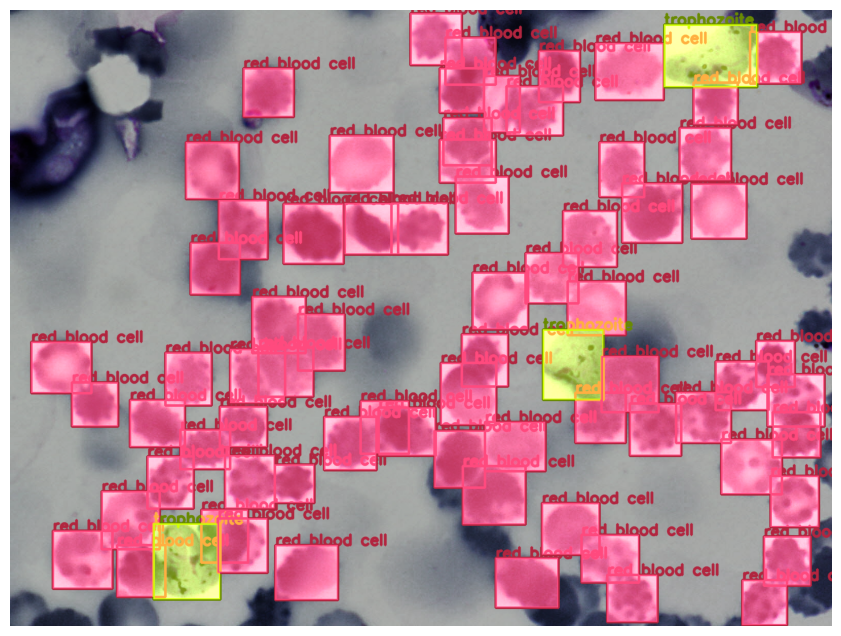

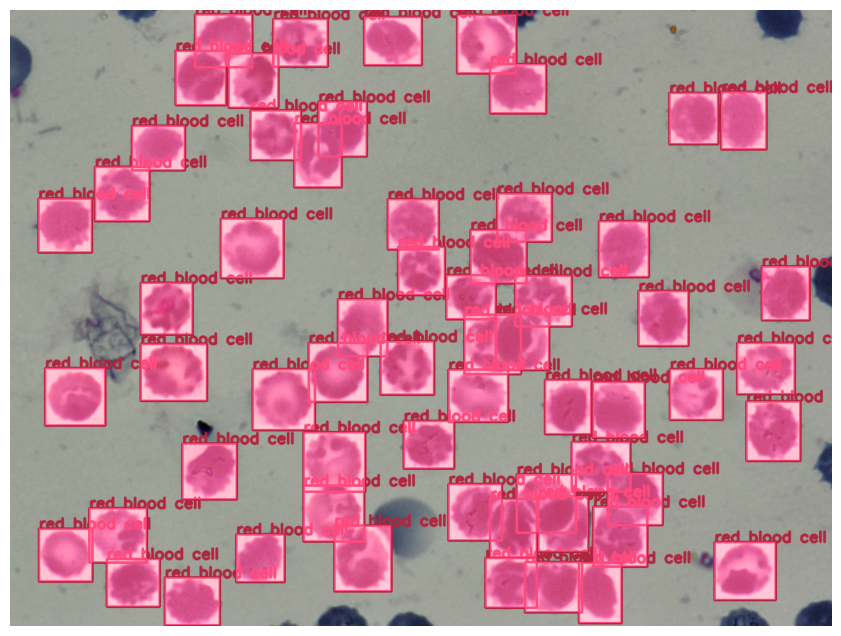

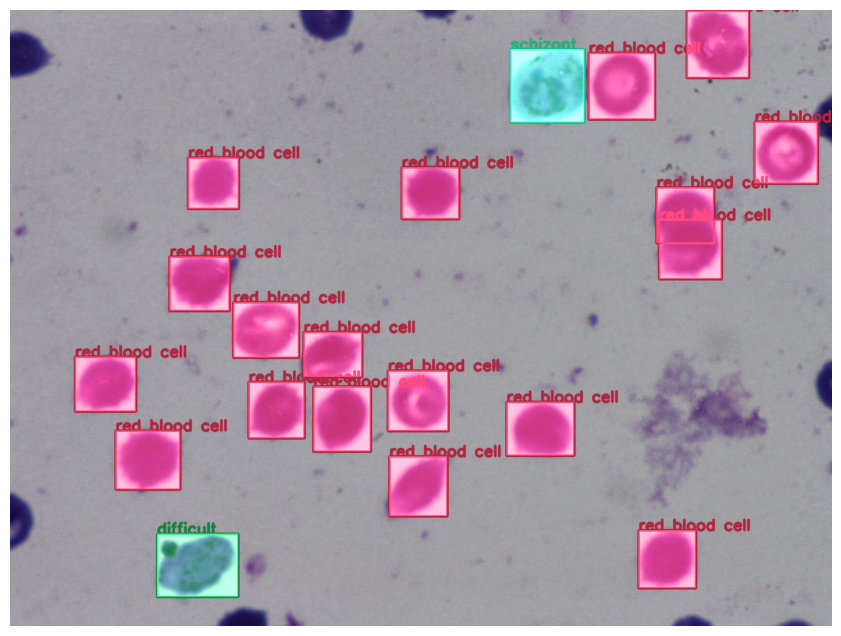

In [ ]:
for i_image, i_targets in zip(images[:3], targets[:3]):
    plot_sample(i_image, i_targets['boxes'], i_targets['labels'])

In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:02<00:00, 69.7MB/s]


In [ ]:
num_classes = 8  # 7 classes + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Load the trained weights
#model.load_state_dict(torch.load('/content/drive/My Drive/fasterrcnn_resnet50_fpn_80_epoch.pth'))

In [ ]:
model.to('cuda')
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.004, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min",
                                           patience=3, verbose=True)
#lr_scheduler = None

num_epochs = 28

In [ ]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [ ]:
loss_hist = Averager()
itr = 1
device= 'cuda'
for epoch in range(num_epochs):
    loss_hist.reset()

    for images, targets, image_ids in train_data_loader:

        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1

    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step(loss_hist.value)

    print(f"Epoch #{epoch} loss: {loss_hist.value}")

Iteration #50 loss: 0.4896847903728485
Iteration #100 loss: 0.3924444913864136
Epoch #0 loss: 0.5098650083966452
Iteration #150 loss: 0.36686569452285767
Iteration #200 loss: 0.3091334104537964
Iteration #250 loss: 0.3194081485271454
Epoch #1 loss: 0.34333389609643855
Iteration #300 loss: 0.324076771736145
Iteration #350 loss: 0.3036101758480072
Iteration #400 loss: 0.3298538327217102
Epoch #2 loss: 0.3084431350843547
Iteration #450 loss: 0.28620511293411255
Iteration #500 loss: 0.25167733430862427
Iteration #550 loss: 0.24742501974105835
Epoch #3 loss: 0.29057938697403424
Iteration #600 loss: 0.32680779695510864
Iteration #650 loss: 0.2840125560760498
Iteration #700 loss: 0.26195383071899414
Epoch #4 loss: 0.28080096483638844
Iteration #750 loss: 0.2871992588043213
Iteration #800 loss: 0.31144535541534424
Iteration #850 loss: 0.25851666927337646
Epoch #5 loss: 0.2741033569590686
Iteration #900 loss: 0.33848485350608826
Iteration #950 loss: 0.2488086223602295
Iteration #1000 loss: 0.27

In [ ]:
torch.save(model.state_dict(), "fasterrcnn_resnet50_fpn_28Epoch.pt")

In [ ]:
def format_prediction(boxes, scores, labels):
    result = np.zeros((len(boxes), 6))

    for i, (j) in enumerate(zip(scores, boxes, labels)):
        result[i, 0] = j[0]
        result[i, 1] = j[1][0]
        result[i, 2] = j[1][1]
        result[i, 3] = j[1][2]
        result[i, 4] = j[1][3]
        result[i, 5] = j[2]

    return result

In [ ]:
# Load the trained weights
model.load_state_dict(torch.load('/content/fasterrcnn_resnet50_fpn_28Epoch.pt'))
model.eval()

detection_threshold = 0.5
results = []
ids = []
device = 'cuda'
model.to(device)
for images, targets, image_ids in valid_data_loader:

    images = list(image.to(device) for image in images)
    outputs = model(images)

    for i, image in enumerate(images):

        boxes = outputs[i]['boxes'].data.cpu().numpy()
        scores = outputs[i]['scores'].data.cpu().numpy()
        labels = outputs[i]['labels'].data.cpu().numpy()

        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        scores = scores[scores >= detection_threshold]
        image_id = image_ids[i]

        result = format_prediction(boxes, scores, labels)
        id_ = [image_id] * result.shape[0]

        results.append(result)
        ids.append(id_)

In [ ]:
len(valid_df.groupby('pathname',axis=0))

160

In [ ]:
len(results)

160

In [ ]:
test_df = pd.DataFrame(np.concatenate(results, axis=0), columns=['score', "x_min", "y_min", "x_max", "y_max", 'label'])
test_df['pathname'] = sum(ids, [])
test_df['category'] = test_df['label'].apply(lambda x: label2category[x])
test_df

score   x_min  y_min   x_max  y_max  label  \
0     0.999275  1174.0  516.0  1304.0  642.0    1.0   
1     0.998779   456.0  228.0   582.0  353.0    1.0   
2     0.998706   868.0  329.0   996.0  451.0    1.0   
3     0.998494   638.0  136.0   757.0  240.0    1.0   
4     0.998441   343.0  521.0   453.0  630.0    1.0   
...        ...     ...    ...     ...    ...    ...   
9748  0.984768  1260.0  585.0  1384.0  698.0    1.0   
9749  0.970856  1736.0  639.0  1827.0  725.0    1.0   
9750  0.959172  1634.0  404.0  1734.0  495.0    1.0   
9751  0.902405  1146.0  800.0  1360.0  937.0    2.0   
9752  0.710157   596.0  391.0   781.0  532.0    2.0   

                                             pathname        category  
0     images/0dcca702-a4ef-4fb3-a940-9c0c140b21c7.png  red blood cell  
1     images/0dcca702-a4ef-4fb3-a940-9c0c140b21c7.png  red blood cell  
2     images/0dcca702-a4ef-4fb3-a940-9c0c140b21c7.png  red blood cell  
3     images/0dcca702-a4ef-4fb3-a940-9c0c140b21c7.png  red blood cell  
4     images/0dcca702-a4ef-4fb3-a940-9c0c140b21c7.png  red blood cell  
...                                               ...             ...  
9748  images/623982a0-1f73-4246-92cb-28f7c219efaf.jpg  red blood cell  
9749  images/623982a0-1f73-4246-92cb-28f7c219efaf.jpg  red blood cell  
9750  images/623982a0-1f73-4246-92cb-28f7c219efaf.jpg  red blood cell  
9751  images/623982a0-1f73-4246-92cb-28f7c219efaf.jpg     trophozoite  
9752  images/623982a0-1f73-4246-92cb-28f7c219efaf.jpg     trophozoite  

[9753 rows x 8 columns]

In [ ]:
test_df['category'].value_counts()

red blood cell    9508
trophozoite        173
ring                41
difficult           16
leukocyte           14
schizont             1
Name: category, dtype: int64

In [ ]:
valid_df.head()

pathname   x_min  y_min   x_max  \
0  images/0dcca702-a4ef-4fb3-a940-9c0c140b21c7.png   455.0  230.0   582.0   
1  images/0dcca702-a4ef-4fb3-a940-9c0c140b21c7.png   587.0  818.0   709.0   
2  images/0dcca702-a4ef-4fb3-a940-9c0c140b21c7.png  1006.0  315.0  1128.0   
3  images/0dcca702-a4ef-4fb3-a940-9c0c140b21c7.png   869.0  334.0   994.0   
4  images/0dcca702-a4ef-4fb3-a940-9c0c140b21c7.png   364.0  633.0   479.0   

   y_max      w      h  label        category  
0  352.0  127.0  122.0      1  red blood cell  
1  930.0  122.0  112.0      1  red blood cell  
2  439.0  122.0  124.0      1  red blood cell  
3  454.0  125.0  120.0      1  red blood cell  
4  751.0  115.0  118.0      1  red blood cell

In [ ]:
valid_df.to_csv('validation_df.csv', index=False)

In [ ]:
test_df.head()

score   x_min  y_min   x_max  y_max  label  \
0  0.999275  1174.0  516.0  1304.0  642.0    1.0   
1  0.998779   456.0  228.0   582.0  353.0    1.0   
2  0.998706   868.0  329.0   996.0  451.0    1.0   
3  0.998494   638.0  136.0   757.0  240.0    1.0   
4  0.998441   343.0  521.0   453.0  630.0    1.0   

                                          pathname        category  
0  images/0dcca702-a4ef-4fb3-a940-9c0c140b21c7.png  red blood cell  
1  images/0dcca702-a4ef-4fb3-a940-9c0c140b21c7.png  red blood cell  
2  images/0dcca702-a4ef-4fb3-a940-9c0c140b21c7.png  red blood cell  
3  images/0dcca702-a4ef-4fb3-a940-9c0c140b21c7.png  red blood cell  
4  images/0dcca702-a4ef-4fb3-a940-9c0c140b21c7.png  red blood cell

In [ ]:
test_df.to_csv('pred_val_df.csv', index=False)

## Result

Ground Truth

In [ ]:
hex2rgb = lambda hx: (int(hx[1:3],16),int(hx[3:5],16),int(hx[5:7],16))
label2rgb = list(map(hex2rgb, custom_colors))[1:]
label2rgb = {k:v for k, v in
               zip(fastercnn_df['category'].value_counts().index.tolist(), label2rgb)}
label2hex = {k:v for k, v in
               zip(fastercnn_df['category'].value_counts().index.tolist(), custom_colors[1:])}

In [ ]:
img_path = test_df["pathname"].sample(1).values[0]

label2hex = {k:v for k, v in
               zip(df['category'].value_counts().index.tolist(), custom_colors[1:])}

plot_data_example(valid_df, config.root_dir, img_path, colors=label2hex)

Prediction

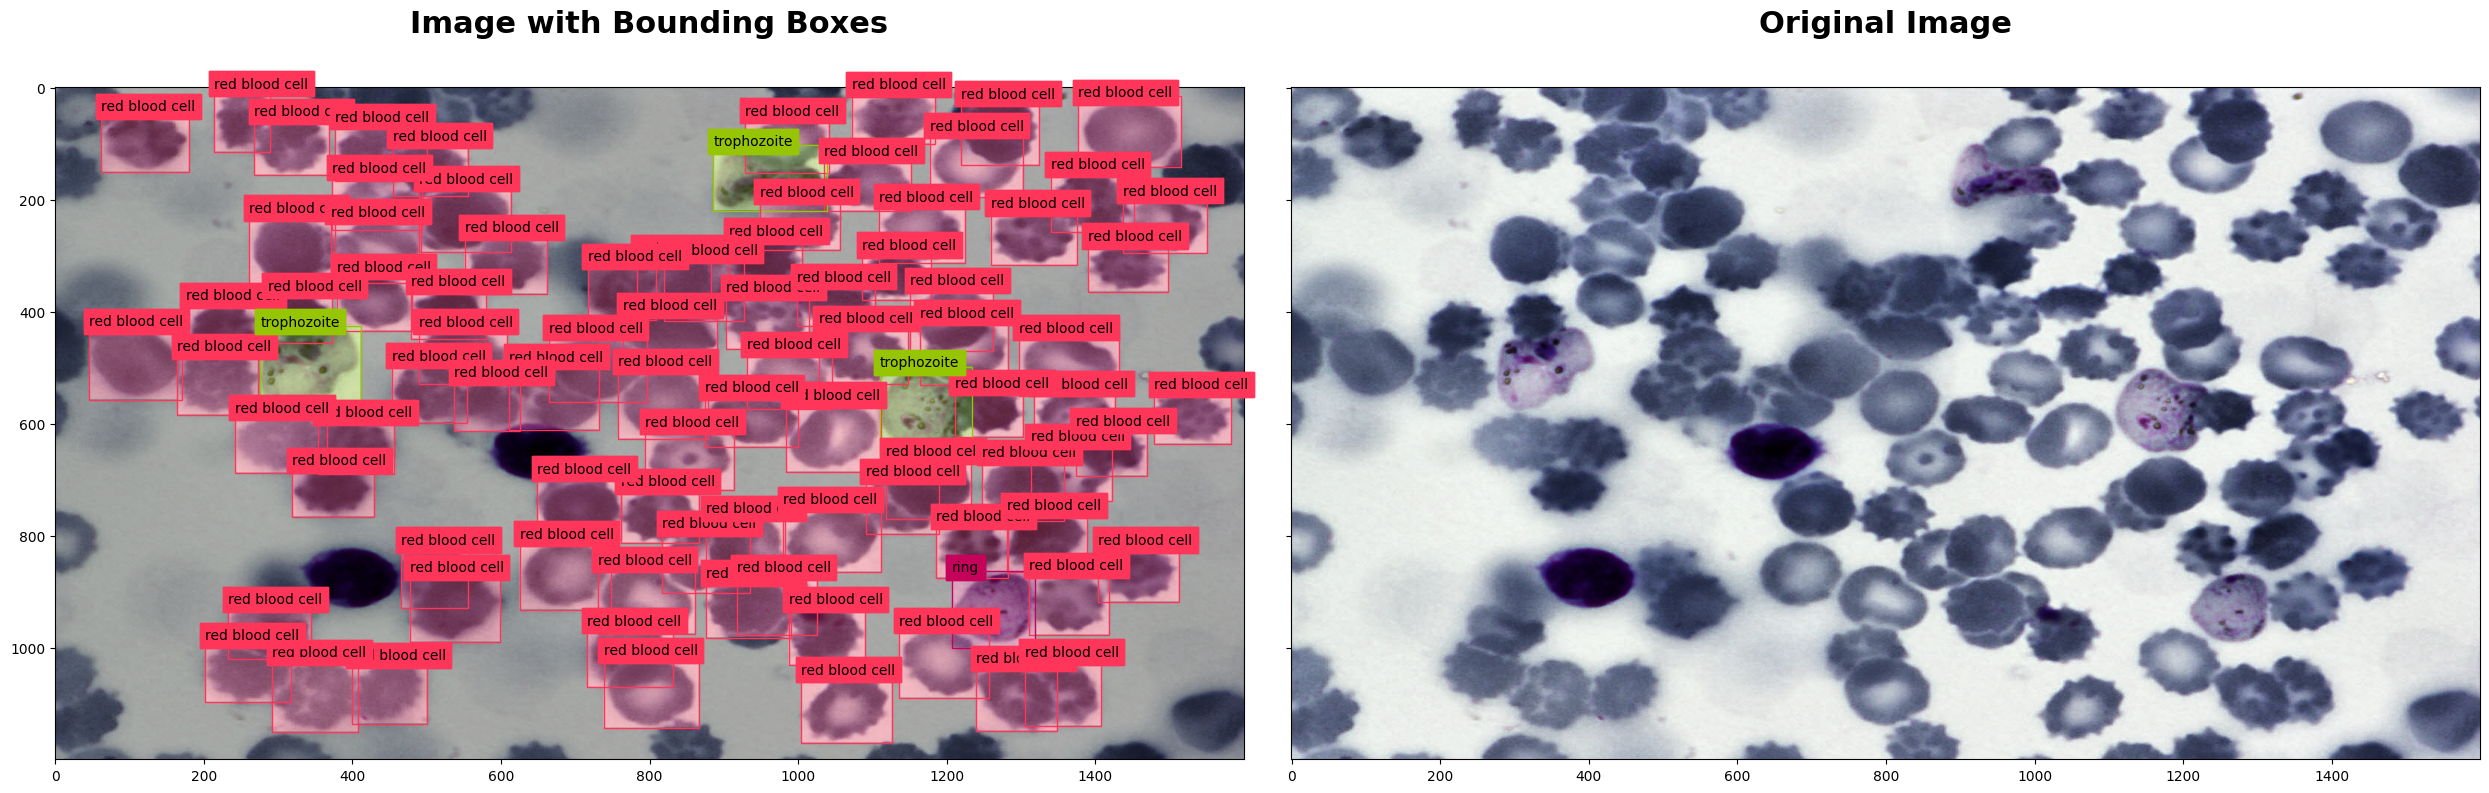

In [ ]:
label2hex = {k:v for k, v in
               zip(df['category'].value_counts().index.tolist(), custom_colors[1:])}

plot_data_example(test_df, config.root_dir, img_path, colors=label2hex)

0.21899380871694382

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/fasterrcnn_resnet50_fpn_28Epoch.pt /content/drive/MyDrive/weights

In [ ]:
! cp /content/validation_df.csv /content/drive/MyDrive/work/FRCNN
! cp /content/pred_val_df.csv /content/drive/MyDrive/work/FRCNN